In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
dataset = torchvision.datasets.ImageFolder(root='./data/EuroSAT_RGB/', transform=data_transforms)

In [8]:
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [9]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


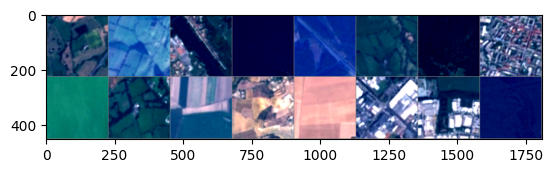

Class Names: Pasture Pasture River SeaLake Highway Pasture Forest Residential SeaLake Pasture AnnualCrop PermanentCrop AnnualCrop Industrial Industrial Forest Residential Forest AnnualCrop AnnualCrop PermanentCrop HerbaceousVegetation Pasture Industrial Forest AnnualCrop Pasture AnnualCrop River PermanentCrop PermanentCrop River Pasture HerbaceousVegetation River SeaLake PermanentCrop Residential SeaLake AnnualCrop Residential River Highway River River SeaLake Industrial AnnualCrop River Residential Industrial Residential River Residential PermanentCrop HerbaceousVegetation River Highway Highway HerbaceousVegetation Residential Forest River Residential


In [15]:
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
for images, labels in trainloader:
    class_names = [dataset.classes[label] for label in labels]  # Map numerical labels to class names
    imshow(torchvision.utils.make_grid(images[:16]))
    print('Class Names:', ' '.join(class_names))
    break 

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2, 2) 
        self.dropout1 = nn.Dropout2d(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64*110*110, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=774400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


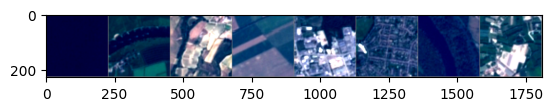

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Pasture HerbaceousVegetation Residential PermanentCrop Industrial Residential HerbaceousVegetation Residential


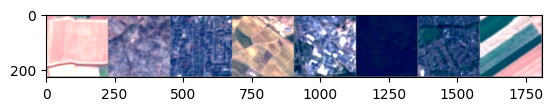

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Residential PermanentCrop HerbaceousVegetation PermanentCrop Highway Pasture HerbaceousVegetation Residential


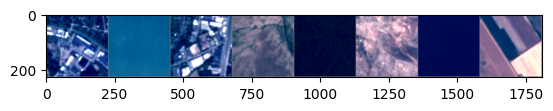

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Industrial SeaLake HerbaceousVegetation Highway Forest HerbaceousVegetation Pasture HerbaceousVegetation


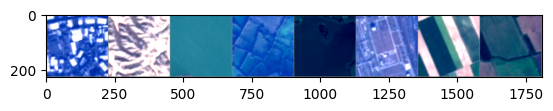

Predicted: Industrial Residential SeaLake SeaLake SeaLake Industrial Industrial Highway


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


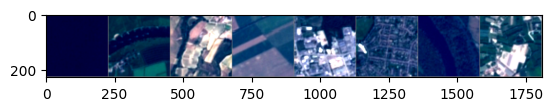

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: SeaLake Highway Residential Highway Industrial Residential Forest Industrial


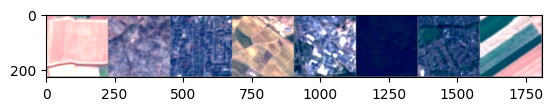

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: AnnualCrop HerbaceousVegetation PermanentCrop Residential Industrial Forest Residential AnnualCrop


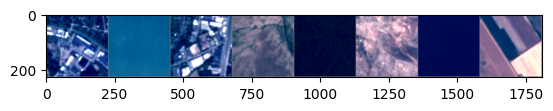

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Industrial Pasture Industrial PermanentCrop Pasture AnnualCrop Pasture PermanentCrop


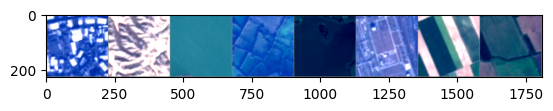

Predicted: Industrial Industrial Pasture Pasture SeaLake Highway Highway Highway


KeyboardInterrupt: 

In [19]:
# Number of training epochs
num_epochs = 5
# max_test_outputs = 4 
testiter = iter(testloader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 20 == 0:
            with torch.no_grad():
            #    test_outputs_counter = 0 
               for test_images, test_labels in testloader:
                    
                    test_images, test_labels = test_images.to(device), test_labels.to(device)

                    imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                    test_outputs = net(test_images[:8])
                    _, predicted = torch.max(test_outputs, 1)
                    
                    # Map numerical labels to class names
                    predicted_classes = [dataset.classes[p] for p in predicted]
                    print('Predicted:', ' '.join(predicted_classes))
                    # test_outputs_counter += 1
                    # if test_outputs_counter >= max_test_outputs:
                    #     break  # Stop after showing 4 test outputs

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")


print('Finished Training')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


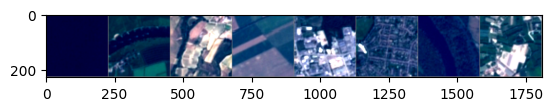

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: SeaLake SeaLake HerbaceousVegetation HerbaceousVegetation SeaLake Residential Pasture Highway


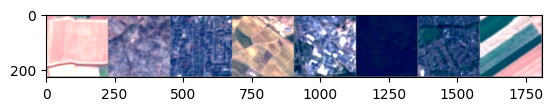

Predicted: Residential Residential Residential PermanentCrop Industrial Pasture SeaLake AnnualCrop
Epoch 1, Loss: 1.7701021432876587


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


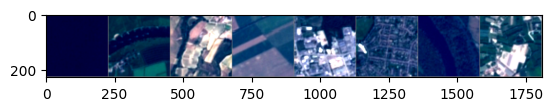

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Forest Forest PermanentCrop HerbaceousVegetation Highway Residential Forest Residential


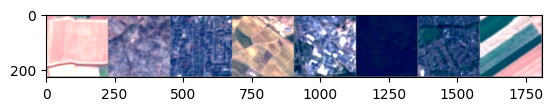

Predicted: Highway Residential HerbaceousVegetation AnnualCrop Residential Forest Residential AnnualCrop
Epoch 2, Loss: 1.8996604084968567


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


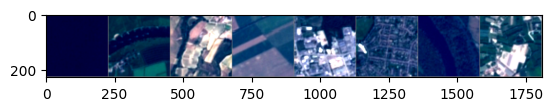

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Pasture Forest AnnualCrop HerbaceousVegetation Residential Forest Forest Pasture


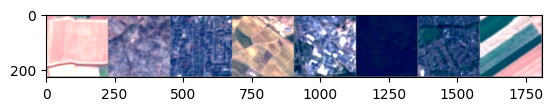

Predicted: AnnualCrop HerbaceousVegetation Residential AnnualCrop Residential Forest Residential Highway
Epoch 3, Loss: 1.855976402759552


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


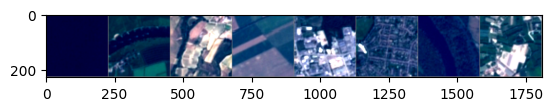

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Forest SeaLake HerbaceousVegetation AnnualCrop Residential HerbaceousVegetation Forest Residential


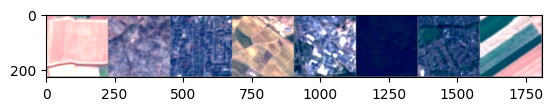

Predicted: AnnualCrop HerbaceousVegetation HerbaceousVegetation AnnualCrop HerbaceousVegetation Forest PermanentCrop Highway
Epoch 4, Loss: 1.8552402257919312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


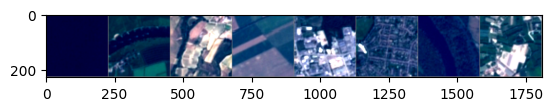

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: Forest Forest HerbaceousVegetation Highway Industrial HerbaceousVegetation Forest Residential


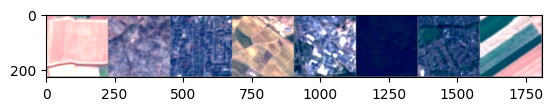

Predicted: Residential Residential Residential PermanentCrop Residential Forest River SeaLake
Epoch 5, Loss: 1.6887507438659668
Finished Training


In [22]:
num_epochs = 5
subset_size = 100  # Set the size of the smaller subset

# Create smaller subsets of the training and test datasets
subset_trainset = torch.utils.data.Subset(trainset, range(subset_size))
subset_testset = torch.utils.data.Subset(testset, range(subset_size))

# Create DataLoaders for the subsets
subset_trainloader = DataLoader(subset_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
subset_testloader = DataLoader(subset_testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(subset_trainloader, 0):  # Use the subset_trainloader
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 20 == 0:
            with torch.no_grad():
                for test_images, test_labels in subset_testloader:  # Use the subset_testloader
                    
                    test_images, test_labels = test_images.to(device), test_labels.to(device)

                    imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                    test_outputs = net(test_images[:8])
                    _, predicted = torch.max(test_outputs, 1)
                    
                    # Map numerical labels to class names
                    predicted_classes = [dataset.classes[p] for p in predicted]
                    print('Predicted:', ' '.join(predicted_classes))

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")

print('Finished Training')

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for test_images, test_labels in subset_testloader:  # Use subset_testloader
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = net(test_images)
        _, predicted = torch.max(test_outputs, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

accuracy = correct / total
print('Test-set Accuracy:', accuracy)

Test-set Accuracy: 0.32


C:\Users\david\AppData\Roaming\Python\Python311\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


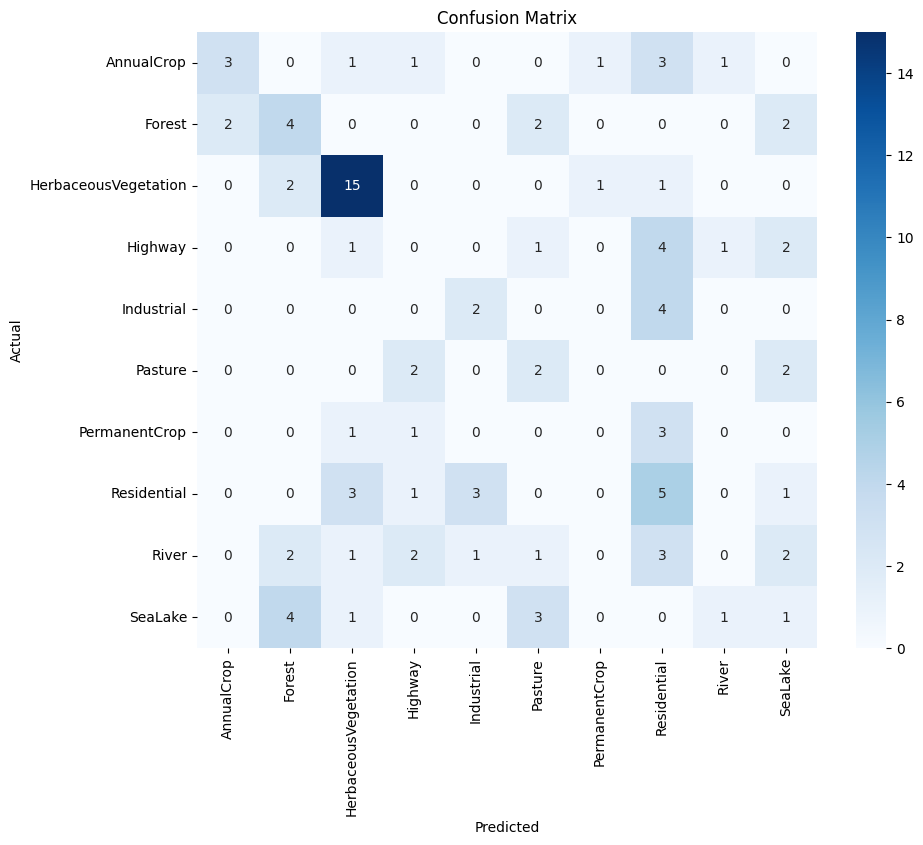

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

actual_labels = []
predicted_labels = []

with torch.no_grad():
    for test_images, test_labels in subset_testloader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = net(test_images)
        _, predicted = torch.max(test_outputs, 1)
        actual_labels.extend(test_labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()